<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA0_52_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA 0.52
### Notes:

### 0.46
*Formatting* now works even if "basemetadata" is not given. Also, in *Formatting*, the parameter for specifying whether normalization is performed changed from "normalizeq" to "normalize".

## Setup

In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314948 sha256=221a70b9b0cef17805de1af31f4b72a1f6ba36beabe3f87a2780d0081ab3647e
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2
rm: cannot remove 'rELA': No such file or directory
Cloning into 'rELA'...
remote: Enumerating objects: 636, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 636 (delta 240), reused 262 (delta 205), pack-reused 332 (from 1)
Receiving objects: 100% (636/636), 7.66 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [2]:
%%R
# [for Google Colab]
# from v0.50, Due to errors in installing igraph and tidygraph
#system("add-apt-repository -y ppa:marutter/rrutter4.0")
#system("add-apt-repository -y ppa:c2d4u.team/c2d4u4.0+")
#system("add-apt-repository ppa:cran/v8")
#system("apt-get update")
#system("apt-get install libnode-dev")
#system("apt-get install r-cran-igraph r-cran-tidygraph")

NULL


In [2]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('plyr')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('plyr')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R
# install rELA package
install.packages("rELA/rELA.v0.52.tar.gz")
library("rELA")

In [15]:
%%R
remove.packages("rELA")

In [4]:
## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Cloning into 'rELA'...
remote: Enumerating objects: 633, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 633 (delta 234), reused 115 (delta 115), pack-reused 332 (from 1)
Receiving objects: 100% (633/633), 7.75 MiB | 31.25 MiB/s, done.
Resolving deltas: 100% (292/292), done.


## Energy Landscape Analysis

### Download data

In [4]:
%%R
# Specify the path for your own data in the code below, if necessary.
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [5]:
%%R
head(basemetadata, 7)

         factor.1   factor.2
sample.1    -0.92 2.79692115
sample.2     0.34 2.14701252
sample.3    -0.92 1.60611363
sample.4    -0.24 0.58476465
sample.5     0.40 1.73161379
sample.6    -0.82 2.95971753
sample.7     0.36 0.07787331


In [6]:
%%R
# To group species with the same presence/absence pattern into one group,
#set grouping to 1 and specify a number between 0 and 1 for grouping_th.
# If 0, only species with the same presence/absence pattern will be grouped together.
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata=NULL, normalize=1, parameters=c(0.01, 0.01, 0.99), grouping=1, grouping_th=0.)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


### Parameter fitting

In [7]:
%%R
#runSA: ocmatrix, env (environmental parameters; with>SA / without>fullSA), qth (threshold for stopping computation), rep (number of fitting processes to compute mean parameter value), threads (number of parallel threads)
sa <- runSA(ocmat=as.matrix(ocmat), qth=10^-5, rep=256, threads=1)


Start parameter fitting:
................................................................................................................................................................................................................................................................SA: elapsed time 43.23 sec



In [19]:
%%R
list[he,je,ge,hge] <- sa2params(sa)

In [20]:
%%R
he

 species.12  species.16   species.7   species.5   species.2  species.10 
-0.77334962 -0.49355976 -0.32744874 -0.41205460 -0.95545122 -1.07214799 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.25432762 -0.49320473 -0.12330308 -0.06972097  1.41226868  0.11649212 
  species.3  species.13   species.1   species.9 
 0.07094419  0.01559590  0.99444523  0.90788476 


In [21]:
%%R
hge

 species.12  species.16   species.7   species.5   species.2  species.10 
-0.77334962 -0.49355976 -0.32744874 -0.41205460 -0.95545122 -1.07214799 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.25432762 -0.49320473 -0.12330308 -0.06972097  1.41226868  0.11649212 
  species.3  species.13   species.1   species.9 
 0.07094419  0.01559590  0.99444523  0.90788476 


### Analysis and visualization of energy landscape
#### ELA function

In [22]:
%%R
ela <- ELA(sa, env=NULL,
                SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
                threads=2, reporting=TRUE)

Start ELA:
7 stable states were found.
Checking 21 tipping points.
converting...
ELA: elapsed time 1.11 sec


In [23]:
%%R
elap <- ELPruning(ela, th=0.2)

Start pruning:
*......
ELPruning: elapsed time 0.46 sec


*ATTENTION*  
The return value of ELPruning is a list consisting of two elements, the first of which takes the same form as ELA, and the second of which indicates the correspondence between the stable states before and after pruning.

In [24]:
%%R
list[stablestates, stablen, tippingpoints, tippingen] <- elap[[1]]

Stable states

In [25]:
%%R
stablestates

[1] "EWB" "09x" "1uV"


Convert an integer representing a stable state (ssid) to a binary vector

In [26]:
%%R
# ssid -> binary vector
bin = as.list(lapply(stablestates, function(x){id2bin(x, ncol(ocmat))}))
names(bin) <- stablestates
bin

$EWB
 [1] 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1

$`09x`
 [1] 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1

$`1uV`
 [1] 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1



Convert a binary vector to a ssid

In [27]:
%%R
# binary vector -> ssid
as.vector(sapply(bin, bin2id))

[1] "EWB" "09x" "1uV"


Table of SSID, Energy, Community composition

In [47]:
%%R
sstable(elap[[1]]) # or sstable(ela)

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 EWB -21.9433957692126          1          1         1         0         1
2 09x -21.4989774614314          0          0         0         0         0
3 1uV -19.4803051391113          0          0         0         1         1
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         0          0          0         0         0          0
2          0         1          0          0         1         1          1
3          1         1          0          0         0         0          1
  species.3 species.13 species.1 species.9
1         1          0         1         1
2         1          0         1         1
3         1          1         1         1


Export the table to Google Drive in CSV format

In [ ]:
%%R
write.csv(x = sstable, file="drive/MyDrive/colab_export/sstable.csv") # "sstable.csv" is saved in "colab_export" folder of your Google Drive.

ID and energy of tipping points

In [48]:
%%R
as.data.frame(tippingpoints)

   X1  X2  X3
1 Inf 4eB 4eB
2 Inf Inf 0O/
3 Inf Inf Inf


In [49]:
%%R
as.data.frame(tippingen)

   X1        X2        X3
1 Inf -13.33333 -13.33333
2 Inf       Inf -16.70655
3 Inf       Inf       Inf


Table of TPID, SSID1, SSID2, Energy, Community composition

In [50]:
%%R
tptable(elap[[1]])

   TP SS1 SS2            Energy species.12 species.16 species.7 species.5
1 4eB 09x EWB -13.3333313355897          0          1         0         0
2 4eB 1uV EWB -13.3333313355897          0          1         0         0
3 0O/ 1uV 09x -16.7065527381469          0          0         0         0
  species.2 species.10 species.8 species.11 species.15 species.6 species.4
1         1          0         1          0          0         0         0
2         1          0         1          0          0         0         0
3         0          1         1          0          0         0         1
  species.14 species.3 species.13 species.1 species.9
1          0         1          0         1         1
2          0         1          0         1         1
3          1         1          1         1         1


Energy of any community composition


In [51]:
%%R
cEnergy(ocmat[1,], he, je)

[1] -3.091967


Find the stable state for a community composition

In [52]:
%%R
Bi(ocmat[1,], he, je)

[[1]]
[1] "01t"

[[2]]
[1] -11.64176



### Principal component analysis  
Observed community compositions plotted on a PC1,2 plane and color-coded by their stable states

NULL


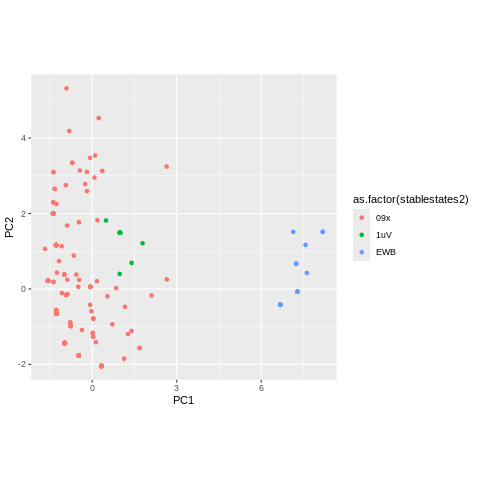

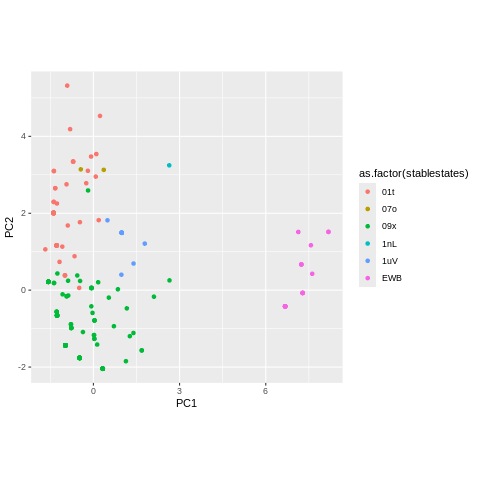

In [53]:
%%R
PCplot(ocmat, sa, ssrep=elap[[2]])
PCplot(ocmat, sa, ssrep=elap[[2]], pruned=FALSE)

Disconnectivity graph


NULL


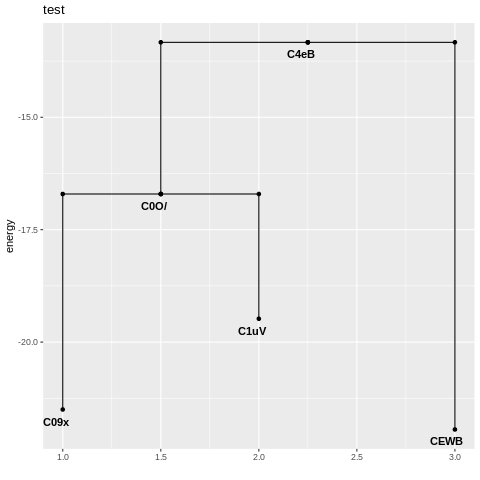

In [54]:
%%R
showDG(elap[[1]], ocmat, "test")

### Visualization of species' interaction

NULL


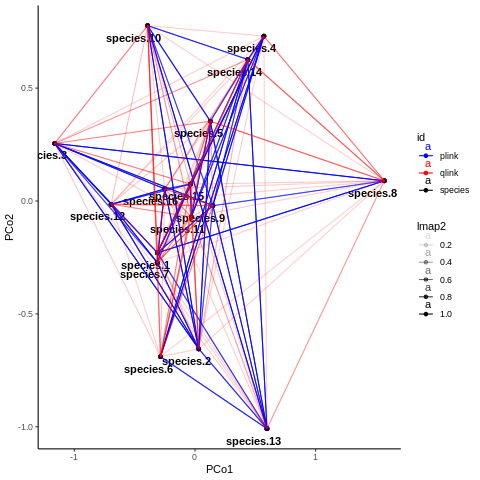

In [55]:
%%R
showIntrGraph(elap[[1]], sa, th=0.01, # <- Threshold for links to be displayed
              annot_adj=c(0.75, 2.00))

### Energy landscape analysis with environmental gradients

In [8]:
%%R
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [9]:
%%R
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata, 1, c(0.01, 0.01, 0.99), 1, 0)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


In [10]:
# Parameter fitting including environmental parameters
%%R
sa <- runSA(ocmat=as.matrix(ocmat), enmat=as.matrix(enmat), qth=10^-5, rep=256, threads=1)

Start parameter fitting
................................................................................................................................................................................................................................................................SA: elapsed time 48.02 sec



In [11]:
%%R
gela <- GradELA(sa=sa, eid="factor.1", # Specify the label or position of an environmental factor
  enmat=enmat, env=NULL, range=NULL, steps=32, th=0.05, threads=2) #[[1]]: return value of ELA function for each step, [[2]]: value of environmental factor for each step, [[3]]: specified environmental factor

env not specified, the mean of enmat is used
processing(32) |================================|
Elapsed time 43.88 sec


NULL


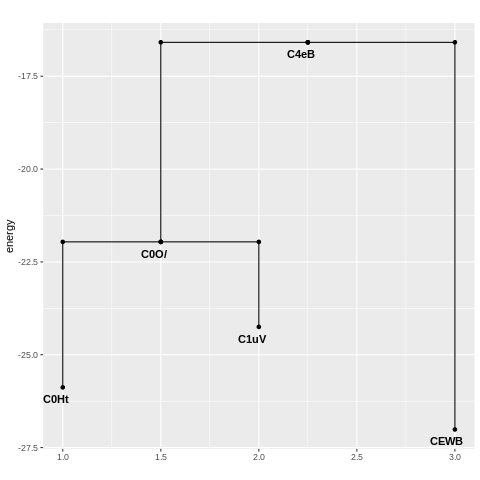

In [12]:
# Disconnectivity graph
%%R
showDG(gela[[1]][[1]][[1]], ocmat)

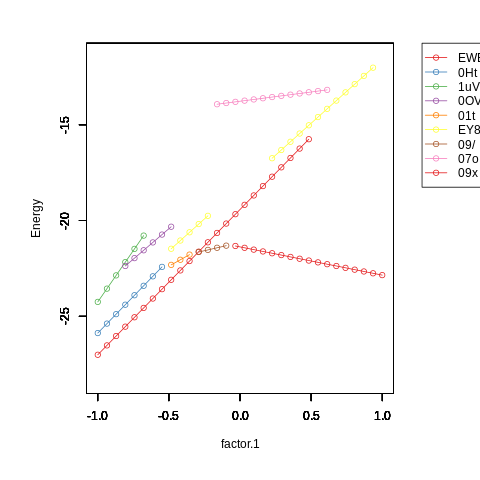

In [13]:
# Stable state diagram
%%R
showSSD(gela)

In [14]:
%%R
gstates <- foreach(x=gela[[1]], .combine='c') %do% {
    x[[1]][[1]]}
unique(gstates)

[1] "EWB" "0Ht" "1uV" "0OV" "01t" "EY8" "09/" "07o" "09x"


#### GradELA 3D plot

In [15]:
%%R
gelsobj <- GELSObj(gela, sa, threads=2)

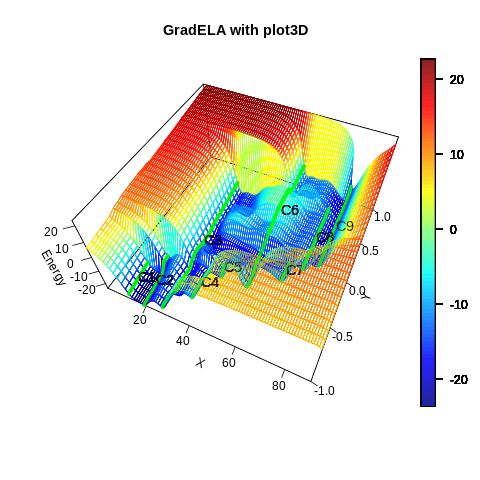

In [16]:
%%R
showGELA3D(gelsobj)

## Stability

In [17]:
%%R
stb <- Stability(sa, ocmat, enmat=NULL, threads=2)
head(stb, 5)

Start Stability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
Stability: elapsed time 10.38 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1   10.8455245  0.0000000  -1.307465 -12.15299      07/             09x
sample.10   1.3566480  0.0000000 -19.005903 -20.36255      08/             09x
sample.100  6.2041267  0.5491529 -13.542267 -19.74639      1uF             09x
sample.101  0.5186412  0.0000000 -20.794828 -21.31347      09t             09x
sample.102  0.8448460  0.0000000 -20.370994 -21.21584      01t             09x


In [18]:
%%R
stbwe <- Stability(sa, ocmat, enmat=enmat, threads=2)
head(stbwe, 5)

Start Stability:
Stability: elapsed time 34.62 sec

             energy.gap ss.entropy  e.realize  e.stable state.id
sample.1   8.926218e+00  1.3970605  -7.347538 -16.27376      07/
sample.10  2.150809e+00  0.3154191 -18.520356 -20.67117      08/
sample.100 1.469554e+00  1.5802338 -22.312076 -23.78163      1uF
sample.101 3.353980e-01  1.1488262 -21.172591 -21.50799      09t
sample.102 3.552714e-15  1.8381178 -22.336746 -22.33675      01t
           stable.state.id
sample.1               0Ht
sample.10              09x
sample.100             1uV
sample.101             01t
sample.102             01t


gStability returns a list of 4 elements: the first two are the dataframe for pruned/non-pruned energy landscape, respectively. In addition to the dataframe of Stability it includes e.tipping (energy of tipping point) and energy.barrier (height of energy from observed state to the tipping point).The third output is a list of parameters (h, g, j, h+g*env) and a summary table of stable states, and the fourth output is a list encapsulating the inputs required for the various plots.  
  
output of gStability:  
[[1]]: data.frame(energy.gap, ss.entropy, energy.barrier, e.realize, e.stable, e.tipping, state.id, stable.state.id)  
[[2]]: data.frame(energy.gap.np, ss.entropy.np, energy.barrier.np, e.realize, e.stable.np, e.tipping.np, state.id.np, stable.state.id.np)  
[[3]]: w/ enmat: list(list(list(he, je, ge, hge), data.frame(sstable)), ...); w/o enmat: list(list(he, je, ge, hge), data.frame(sstable))  
[[4]]: w/ enmat: list(list(ocmat, env, sa, ela, elanp), ...); w/o enmat: list(ocmat, env, sa, ela, elanp)

In [19]:
%%R
gstb <- gStability(sa, ocmat, enmat=NULL, threads=2)

Start gStability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
gStability: elapsed time 22.27 sec



In [21]:
%%R
gstb[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable e.tipping
sample.1   20.2747526  0.0000000       7.594653  -1.307465 -21.58222 -13.98756
sample.10   2.5763150  0.5264795       7.594653 -19.005903 -21.58222 -13.98756
sample.100  8.0399501  0.8016291       7.594653 -13.542267 -21.58222 -13.98756
sample.101  0.7873894  0.0000000       7.594653 -20.794828 -21.58222 -13.98756
sample.102  1.2112233  0.6778845       7.594653 -20.370994 -21.58222 -13.98756
sample.103  3.1159454  0.0000000       7.594653 -18.466272 -21.58222 -13.98756
sample.104  0.3552743  0.0000000       7.594653 -21.226943 -21.58222 -13.98756
sample.105  1.8955975  0.9483407       5.913876 -18.005843 -19.90144 -13.98756
           state.id stable.state.id
sample.1        07/             09x
sample.10       08/             09x
sample.100      1uF             09x
sample.101      09t             09x
sample.102      01t             09x
sample.103      0Ht             09x
sample.104      09/             09x
s

In [22]:
%%R
gstb[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1      10.8455245     0.0000000         -1.834575  -1.307465   -12.15299
sample.10      1.3566480     0.0000000          6.374986 -19.005903   -20.36255
sample.100     6.2041267     0.4689956          5.758830 -13.542267   -19.74639
sample.101     0.5186412     0.0000000          7.325905 -20.794828   -21.31347
sample.102     0.8448460     0.0000000          7.228276 -20.370994   -21.21584
sample.103     2.4617226     0.2990066          6.940430 -18.466272   -20.92799
sample.104     0.2966427     0.0000000          7.536021 -21.226943   -21.52359
sample.105     2.0353169     0.1062737          6.053595 -18.005843   -20.04116
           e.tipping.np state.id.np stable.state.id.np
sample.1      -13.98756         07/                09x
sample.10     -13.98756         08/                09x
sample.100    -13.98756         1uF                09x
sample.101    -13.98756         09t                09x
sampl

In [23]:
%%R
gstbe <- gStability(sa, ocmat, enmat=enmat, th=0.2, threads=2)

Start gStability:
gStability: elapsed time 230.09 sec



In [24]:
%%R
length(gstbe[[4]])

[1] 256


In [25]:
%%R
gstbe[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable  e.tipping
sample.1   17.7012235  0.5656087      12.713833  -7.347538 -25.04876 -12.334929
sample.10   3.3704757  0.0000000       8.873798 -18.520356 -21.89083 -13.017034
sample.100  3.1396895  0.8800651      12.871588 -22.312076 -25.45177 -12.580177
sample.101  0.3741211  0.6484722       7.355477 -21.172591 -21.54671 -14.191235
sample.102  0.0000000  0.9118319      14.332850 -22.336746 -22.33675  -8.003896
sample.103  0.0000000  0.8554508      13.435335 -23.902535 -23.90254 -10.467201
sample.104  0.6503647  0.0000000       8.474046 -20.810992 -21.46136 -12.987311
sample.105  0.7412253  0.7849193       5.731763 -18.535508 -19.27673 -13.544970
           state.id stable.state.id
sample.1        07/             0Ht
sample.10       08/             09x
sample.100      1uF             0Ht
sample.101      09t             09/
sample.102      01t             01t
sample.103      0Ht             0Ht
sample.104      09/         

In [26]:
%%R
gstbe[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1    8.926218e+00     0.3392404        -4.9233750  -7.347538   -16.27376
sample.10   2.150809e+00     0.0000000         7.6541314 -18.520356   -20.67117
sample.100  1.469554e+00     1.6156631         1.8799942 -22.312076   -23.78163
sample.101  3.353980e-01     0.9999971         0.3353980 -21.172591   -21.50799
sample.102  3.552714e-15     1.0376732         0.5424818 -22.336746   -22.33675
sample.103  3.552714e-15     0.7289810         3.1648639 -23.902535   -23.90254
sample.104  5.917331e-01     0.1300588         8.2362428 -20.810992   -21.40273
sample.105  8.809447e-01     0.6298953         5.8714827 -18.535508   -19.41645
           e.tipping.np state.id.np stable.state.id.np
sample.1      -21.19713         07/                0Ht
sample.10     -13.01703         08/                09x
sample.100    -21.90164         1uF                1uV
sample.101    -21.17259         09t                01t
sampl

===================================================================================

In [27]:
## list(he,je,ge,hge)
%%R
sample.id <- 1
gstbe[[3]][[sample.id]][[1]]
# if enmat=NULL, remove "[[sample.id]]"

[[1]]
 species.12  species.16   species.7   species.5   species.2  species.10 
-0.71686320 -0.44997484 -0.44679022 -0.27247839 -1.08745852 -1.32903118 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.22857564 -0.55720467 -0.39250493 -0.10103004  1.30760858  0.23474556 
  species.3  species.13   species.1   species.9 
 0.01188203 -0.23801105  0.78607944  0.99645190 

[[2]]
           species.12 species.16  species.7   species.5  species.2  species.10
species.12  0.0000000  1.6014651  1.5761175 -0.99174317  1.1715140 -1.15563956
species.16  1.6014651  0.0000000  1.3289466 -1.06551678  0.8373580 -1.30093091
species.7   1.5761175  1.3289466  0.0000000 -1.08240534  0.7753357 -0.95429951
species.5  -0.9917432 -1.0655168 -1.0824053  0.00000000  1.3345070  0.30342047
species.2   1.1715140  0.8373580  0.7753357  1.33450701  0.0000000  0.29310017
species.10 -1.1556396 -1.3009309 -0.9542995  0.30342047  0.2931002  0.00000000
species.8  -2.0892545 -1.5368612 -1.4595114 

In [28]:
## stablestates
%%R
sample.id <- 100
gstbe[[3]][[sample.id]][[2]]
# if enmat=NULL, remove "[[sample.id]]

   ID           Energy species.12 species.16 species.7 species.5 species.2
1 09x -22.758817060946          0          0         0         0         0
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
  species.3 species.13 species.1 species.9
1         1          0         1         1


In [29]:
%%R
length(gstbe[[4]][[1]][[4]][[1]][[1]])

[1] 2


In [30]:
%%R
sapply(seq(256), function(x) {length(gstbe[[4]][[x]][[4]][[1]][[1]]) - length(gstbe[[4]][[x]][[5]][[1]])})

  [1] -3 -2 -2 -2 -3 -2 -1 -1 -1 -2 -1 -2 -2 -3 -2 -1 -1 -2 -3 -1 -2  0 -2 -3 -2
 [26]  0 -2 -2 -4 -2  0 -2 -3 -2 -2 -2 -3 -3 -1 -2 -2 -3 -2 -2 -3 -3 -3 -2 -1 -2
 [51] -2 -2  0 -2 -2 -1 -2 -1 -3 -2 -2 -2  0 -2 -2 -2 -4 -3 -2 -2 -2 -2 -1 -1  0
 [76] -2 -1 -3 -1 -3 -4 -1  0 -4 -2 -1 -2 -2 -1 -2 -2 -1 -2 -1  0 -2 -3 -2 -2  0
[101] -3 -2 -2 -1 -2 -1 -3 -2 -2  0 -4 -2  0 -2 -2 -3 -3 -2 -3 -1 -4 -2 -2 -2 -2
[126] -1 -2 -2 -4 -1 -1 -2 -2 -1 -3 -2 -3 -3 -2  0 -1 -2 -1 -2  0 -3 -4 -3 -1 -4
[151] -2  0 -2  0 -1 -3 -2 -2 -2 -2 -2 -2 -2 -4 -2 -2 -1  0 -2 -2  0 -2 -2 -3 -2
[176] -2 -3 -3 -2 -2  0  0 -4 -2 -1 -3 -2 -3 -2 -2 -3 -2 -1  0 -1 -1 -1 -2 -1 -2
[201] -3 -2 -2 -4 -2 -3  0 -2 -3 -2 -2 -2 -5 -3 -2 -2 -1 -3 -2 -2 -3 -2 -1  0 -2
[226]  0 -2 -2 -2 -3 -2 -3 -2 -2 -2 -4  0 -4  0 -2 -2  0 -2 -2 -2 -2  0 -1 -3 -4
[251] -3 -2 -2 -2 -2 -2


In [31]:
%%R
ela <- gstbe[[4]][[sample.id]][[4]]
ela

[[1]]
[[1]][[1]]
[1] "09x"

[[1]][[2]]
[1] -22.75882

[[1]][[3]]
[[1]][[3]]$`1`
[1] "Inf"


[[1]][[4]]
[[1]][[4]]$`1`
[1] Inf



[[2]]
  ss.before.pruning ss.after.pruning
1               09x              09x



In [32]:
%%R
elanp <- gstbe[[4]][[sample.id]][[5]]
elanp

[[1]]
[1] "09x"

[[2]]
[1] -22.75882

[[3]]
[[3]]$`1`
[1] "Inf"


[[4]]
[[4]]$`1`
[1] Inf




NULL


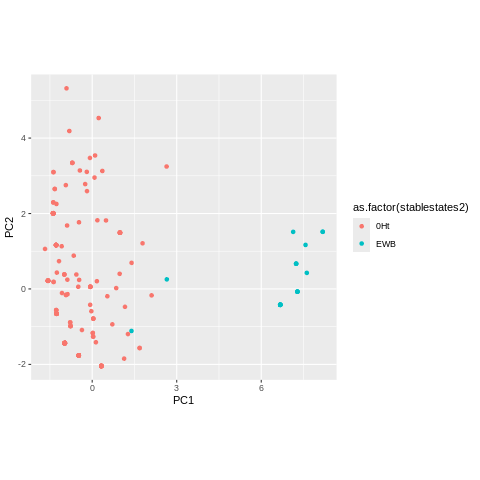

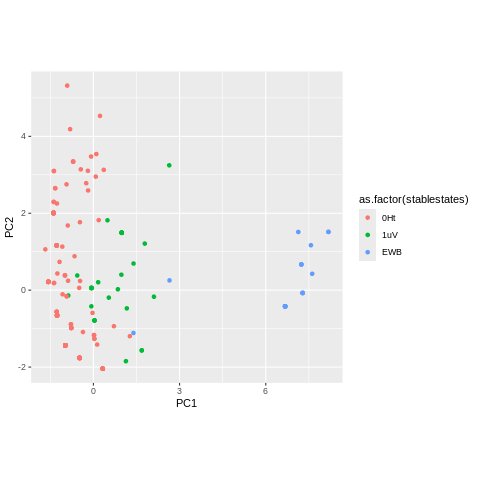

In [33]:
## PCplot
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
env <- gstbe[[4]][[sample.id]][[2]]
sa <- gstbe[[4]][[sample.id]][[3]]
ela <- gstbe[[4]][[sample.id]][[4]]
# if enmat=NULL, remove "[[sample.id]]"

PCplot(ocmat, sa, env, ssrep=ela[[2]])
PCplot(ocmat, sa, env, ssrep=ela[[2]], pruned=FALSE)

NULL


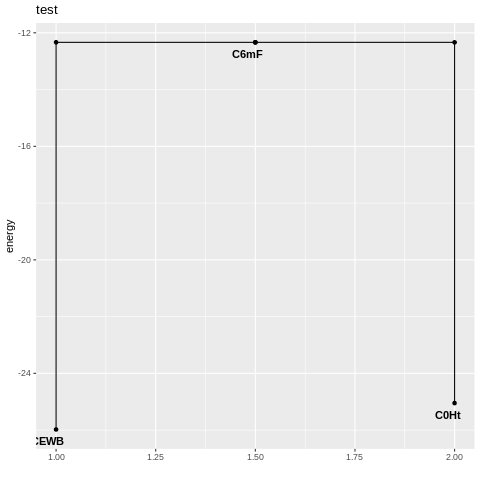

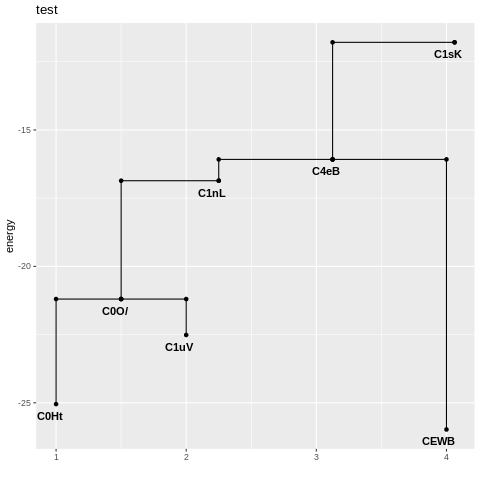

In [34]:
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
ela <- gstbe[[4]][[sample.id]][[4]]
elanp <- gstbe[[4]][[sample.id]][[5]]
# if enmat=NULL, remove "[[sample.id]]"

showDG(ela[[1]], ocmat, "test")
showDG(elanp, ocmat, "test")